# Grad-CAM on Xception
gradient × average


In [2]:
import sys
sys.path.append("/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2")
sys.argv = ["train.py"]

# Loading Model 

In [3]:
from training.detectors import DETECTOR
from training.detectors import xception_detector
import yaml
import os

def load_config(path, additional_args={}):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    config2 = yaml.safe_load(open(path, 'r'))
    if 'label_dict' in config:
        config2['label_dict'] = config['label_dict']
    config.update(config2)
    if config.get('dry_run'):
        config['nEpochs'] = 0
        config['save_feat'] = False
    for key, value in additional_args.items():
        config[key] = value
    return config

/opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/lime/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/lime/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/lime/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installe

In [4]:
path = "/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2/training/config/detector/xception.yaml"
additional_args = {
    'test_batchSize': 12,
    'pretrained': "/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2/weights/ckpt_best.pth"
}
config = load_config(path, additional_args=additional_args)
model_class = DETECTOR[config["model_name"]]
model = model_class(config)
model.eval()

/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2/training/detectors/xception_detector.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = 

XceptionDetector(
  (backbone): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [5]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Loading Grid 

In [6]:
class MyToTensor(transforms.ToTensor):
    def __call__(self, input_img):
        if not isinstance(input_img, torch.Tensor):
            return super().__call__(input_img)
        return input_img

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    MyToTensor(),
])

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, folder_paths, transform=None):
        self.image_files = []
        for fp, label in folder_paths.items():
            self.image_files.extend(
                [(os.path.join(fp, f), label) for f in os.listdir(fp) if f.endswith((".png", ".jpg"))]
            )
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

In [8]:
file_path_deepfakebench = {
    "/Users/msrobin/GitHub Repositorys/Interpretable-Deep-Fake-Detection-2/datasets/2x2_images": 1
}
dataset = CustomImageDataset(file_path_deepfakebench, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Grad Cam 

# Find Last Layer

In [24]:
def print_all_modules(model):
    for name, module in model.named_modules():
        print(f"{name}: {module}")

# Call this function to display all layers and submodules
print_all_modules(model.backbone)


: Xception(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): 

In [39]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d) and 'adjust' not in name:
        print(name)


backbone.conv1
backbone.conv2
backbone.block1.skip
backbone.block1.rep.0.conv1
backbone.block1.rep.0.pointwise
backbone.block1.rep.3.conv1
backbone.block1.rep.3.pointwise
backbone.block2.skip
backbone.block2.rep.1.conv1
backbone.block2.rep.1.pointwise
backbone.block2.rep.4.conv1
backbone.block2.rep.4.pointwise
backbone.block3.skip
backbone.block3.rep.1.conv1
backbone.block3.rep.1.pointwise
backbone.block3.rep.4.conv1
backbone.block3.rep.4.pointwise
backbone.block4.rep.1.conv1
backbone.block4.rep.1.pointwise
backbone.block4.rep.4.conv1
backbone.block4.rep.4.pointwise
backbone.block4.rep.7.conv1
backbone.block4.rep.7.pointwise
backbone.block5.rep.1.conv1
backbone.block5.rep.1.pointwise
backbone.block5.rep.4.conv1
backbone.block5.rep.4.pointwise
backbone.block5.rep.7.conv1
backbone.block5.rep.7.pointwise
backbone.block6.rep.1.conv1
backbone.block6.rep.1.pointwise
backbone.block6.rep.4.conv1
backbone.block6.rep.4.pointwise
backbone.block6.rep.7.conv1
backbone.block6.rep.7.pointwise
backbon

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Wrap your model so Grad-CAM gets only the logits
class WrappedModel(torch.nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.original_model = original_model

    def forward(self, x):
        data_dict = {'image': x}
        out = self.original_model(data_dict)
        return out['cls']  # return logits only

wrapped_model = WrappedModel(model)


#manually find target layer:# for name, module in model.backbone.named_modules():
#    print(name, "->", type(module)) 

#automatic: def find_last_conv_layer(model):
#    for name, module in reversed(list(model.named_modules())):
 #       if isinstance(module, torch.nn.Conv2d):
  #          print(f"Using last Conv2d layer: {name}")
   #         return module
    #raise ValueError("No Conv2d layer found.")

#TARGET_LAYER = find_last_conv_layer(model.backbone)

TARGET_LAYER = dict(model.named_modules())["backbone.conv4.pointwise"] # last conv layer
cam = GradCAM(model=wrapped_model, target_layers=[TARGET_LAYER])


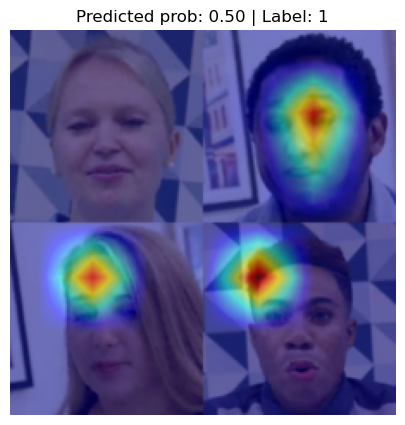

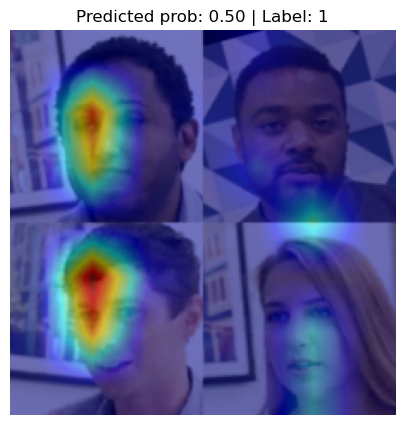

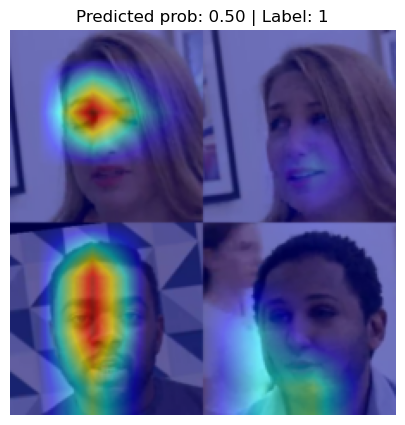

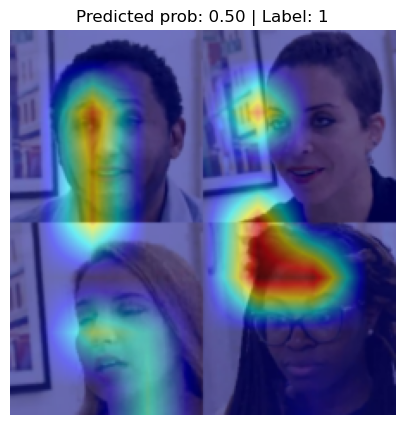

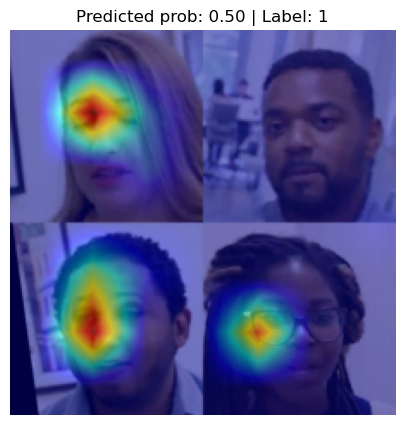

Accuracy: 100.00%


In [10]:
# Initialize counters for accuracy calculation
correct = 0
total = 0

# Start iterating over your DataLoader
for img_batch, label_batch, path_batch in dataloader:
    for i in range(min(5, len(img_batch))):  # Process the first 5 images
        img = img_batch[i].unsqueeze(0).to(device)  # Add batch dimension
        label = label_batch[i].to(device)

        data_dict = {"image": img, "label": label}
        model.zero_grad()
        out = model(data_dict)

        pred_prob = out['prob'].item()
        pred_class = 1 if pred_prob >= 0.5 else 0  # Determine predicted class (fake or real)

        # Accuracy calculation: Compare predicted class with actual label
        if pred_class == label.item():
            correct += 1
        total += 1

        # Grad-CAM generation
        targets = [ClassifierOutputTarget(label.item())]
        grayscale_cam = cam(input_tensor=img, targets=targets)[0]

        img_np = img.squeeze().cpu().numpy().transpose(1, 2, 0)
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize image
        heatmap = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

        # Display the image with Grad-CAM overlay
        plt.figure(figsize=(10, 5))
        plt.imshow(heatmap)
        plt.axis("off")
        plt.title(f"Predicted prob: {pred_prob:.2f} | Label: {label.item()}")
        plt.show()

# After processing, calculate and display the accuracy
accuracy = correct / total * 100
print(f"Accuracy: {accuracy:.2f}%")
